# Ridge and Lasso Regression

In this chapter we explore two variants of linear regression: ridge and lasso.  Both of these are shrinkage methods, meaning that they shrink regression coefficients to zero.  This has the effect of trading a little bit of bias for a reduction in variance.  This can improve model stability and fit.

This tutorial is based on section 6.2 of *Introduction to Statistical Learning 2e*.

## Import Packages

Let's begin by importing the packages that we will need.

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline

## Read-In Data

Next, we'll read-in the data that we will be working with; it is the `Credit` data set from the **ISLR2** R package that can be downloaded from CRAN.

In [ ]:
df_credit = pd.read_csv('credit.csv')
df_credit.columns = df_credit.columns.str.lower()
df_credit

,income,limit,rating,cards,age,education,own,student,married,region,balance
0,14.891,3606,283,2,34,11,No,No,Yes,South,333
1,106.025,6645,483,3,82,15,Yes,Yes,Yes,West,903
2,104.593,7075,514,4,71,11,No,No,No,West,580
3,148.924,9504,681,3,36,11,Yes,No,No,West,964
4,55.882,4897,357,2,68,16,No,No,Yes,South,331
...,...,...,...,...,...,...,...,...,...,...,...
395,12.096,4100,307,3,32,13,No,No,Yes,South,560
396,13.364,3838,296,5,65,17,No,No,No,East,480
397,57.872,4171,321,5,67,12,Yes,No,Yes,South,138
398,37.728,2525,192,1,44,13,No,No,Yes,South,0


## Wrangling Data

Our next task is to preform some wrangling on our data.

We begin by creating dummy variables for all our categorial features.

In [ ]:
df_X = pd.get_dummies(df_credit.drop('balance', axis=1), drop_first=True)
df_y = df_credit[['balance']]

When performing shrinkage methods, it is best to normalize the features.

In [ ]:
from sklearn.preprocessing import scale
X_s = scale(df_X, with_mean=False)

## Ridge Regression

We are now ready to fit a ridge regression so let's import the `Ridge` constructor.

In [ ]:
from sklearn.linear_model import Ridge

### Fitting a Ridge for a Single Value of `alpha`

We begin by fitting a ridge with a single value of `alpha`, which is the parameter that controls the amount of shrinkage to zero.  Higher values correspond to more shrinkage.  An `alpha` value of zero corresponds to the standard least squares model.

Let's start with `alpha` = 1.

In [ ]:
model = Ridge(alpha=1)
model.fit(X_s, df_y)

Ridge(alpha=1)

Next, let's display the coefficients in a `DataFrame`.

In [ ]:
df_coef = pd.DataFrame(
    data = {'coefficient': list(model.intercept_) + list(np.ravel(model.coef_))},
    index = ['intercept'] + list(df_X.columns.values), 
)
df_coef

,coefficient
intercept,-487.398207
income,-271.271818
limit,367.168796
rating,245.258668
cards,21.330598
age,-10.896509
education,-3.013622
own_Yes,-5.222885
student_Yes,126.864176
married_Yes,-4.718335


Notice that effect size of `income`, `limit`, `rating`, and `student_Yes` are by far the largest.  So we will focus on analyzing those in our subsequet analysis when we vary `alpha`.

### Fitting A Ridge for Multiple Values of `alpha`

We are now going fit our ridge model for various values of `alpha` and examine the coefficients and $R^2$.

This code loops through `alpha` values, stores various values in `lists`, and then puts it all together nicely into a `DataFrame`

In [ ]:
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]
income_coef = []
limit_coef = []
rating_coef = []
student_yes_coef = []
r_squared = []
for ix in alpha:
    model = Ridge(alpha=ix)
    model.fit(X_s, df_y)
    coef = np.ravel(model.coef_)
    income_coef.append(coef[0].round(2))
    limit_coef.append(coef[1].round(2))
    rating_coef.append(coef[2].round(2))
    student_yes_coef.append(coef[7].round(2))
    r_squared.append(model.score(X_s, df_y))
df_coefficient = pd.DataFrame(
    {
        'alpha':alpha,
        'income':income_coef,
        'limit':limit_coef,
        'rating':rating_coef,
        'student_Yes':student_yes_coef,
        'r_squared':r_squared,
    }
)
df_coefficient

,alpha,income,limit,rating,student_Yes,r_squared
0,0.001,-274.67,439.94,175.78,127.72,0.955102
1,0.010,-274.64,438.55,177.14,127.71,0.955102
2,0.100,-274.34,426.09,189.33,127.60,0.955097
3,1.000,-271.27,367.17,245.26,126.86,0.954974
4,10.000,-242.12,301.99,281.05,122.99,0.952659
5,100.000,-94.60,211.39,209.60,97.64,0.882671
6,1000.000,22.93,84.08,84.22,34.01,0.550125
7,10000.000,7.31,14.44,14.47,4.57,0.123256
8,100000.000,0.84,1.57,1.57,0.47,0.014014
9,1000000.000,0.09,0.16,0.16,0.05,0.001421


Notice that the $R^2$ decreases monotonically.

Let's now plot the coefficient values for various values of `alpha`.

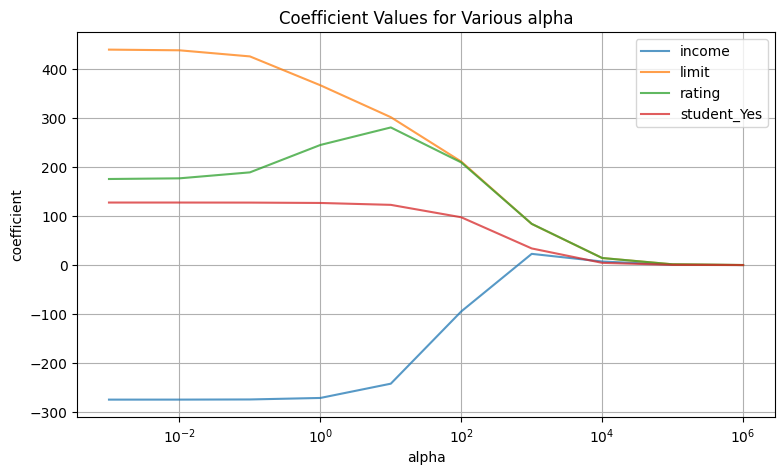

In [ ]:
ax = df_coefficient.\
        plot(
            x = 'alpha',
            y = ['income', 'limit', 'rating', 'student_Yes'],
            title = 'Coefficient Values for Various alpha',
            grid = True,
            alpha = 0.75,
            figsize = (9, 5),
            logx=True,
            );
ax.set_xlabel('alpha');
ax.set_ylabel('coefficient');

As you can see for large values of `alpha` the coefficients are close to zero, however they never quite reach zero.

## Lasso

Let's now repeat the same analysis for lasso regression.  We begin by calculating coefficients and $R^2$ for various values of `alpha`, and then display them in a `DataFrame`.

In [ ]:
from sklearn.linear_model import Lasso
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]
income_coef = []
limit_coef = []
rating_coef = []
student_yes_coef = []
r_squared = []
for ix in alpha:
    model = Lasso(alpha=ix)
    model.fit(X_s, df_y)
    coef = np.ravel(model.coef_)
    income_coef.append(coef[0].round(2))
    limit_coef.append(coef[1].round(2))
    rating_coef.append(coef[2].round(2))
    student_yes_coef.append(coef[7].round(2))
    r_squared.append(model.score(X_s, df_y))
df_coefficient = pd.DataFrame(
    {
        'alpha':alpha,
        'income':income_coef,
        'limit':limit_coef,
        'rating':rating_coef,
        'student_Yes':student_yes_coef,
        'r_squared':r_squared,
    }
)
df_coefficient

/home/pritam/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.516e+06, tolerance: 8.434e+03
  model = cd_fast.enet_coordinate_descent(


,alpha,income,limit,rating,student_Yes,r_squared
0,0.001,-274.67,442.55,173.18,127.74,0.955101
1,0.010,-274.64,444.80,170.89,127.74,0.955101
2,0.100,-274.23,449.54,165.72,127.67,0.955099
3,1.000,-270.07,439.92,171.01,126.60,0.955006
4,10.000,-228.48,335.30,233.09,116.13,0.948874
5,100.000,-0.00,23.36,273.31,19.63,0.718970
6,1000.000,0.00,0.00,0.00,0.00,0.000000
7,10000.000,0.00,0.00,0.00,0.00,0.000000
8,100000.000,0.00,0.00,0.00,0.00,0.000000
9,1000000.000,0.00,0.00,0.00,0.00,0.000000


Once again, $R^2$ decreases monotonically.

Finally, let's plot the coefficients for various values of `alpha`.  Notice that unlike ridge, with lasso the coefficients get squashed to zero.

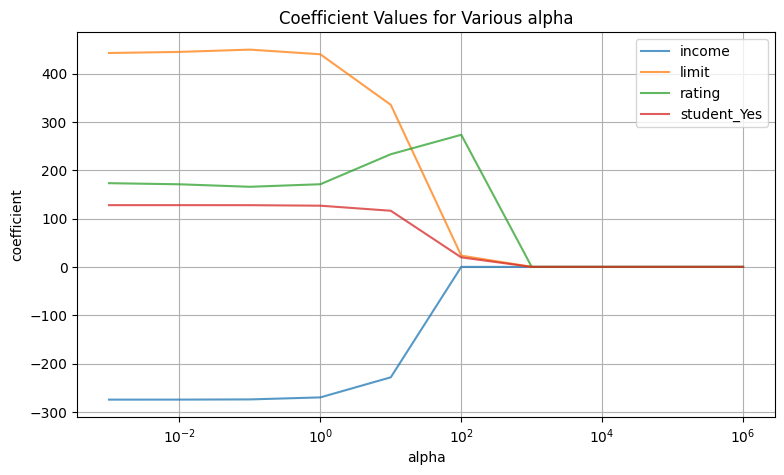

In [ ]:
ax = df_coefficient.\
        plot(
            x = 'alpha',
            y = ['income', 'limit', 'rating', 'student_Yes'],
            title = 'Coefficient Values for Various alpha',
            grid = True,
            alpha = 0.75,
            figsize = (9, 5),
            logx=True,
            );
ax.set_xlabel('alpha');
ax.set_ylabel('coefficient');